## Phase 1: Environment Setup & Data Ingestion


**Tujuan:** Untuk memuat semua dataset mentah dari berbagai file `.json`, melakukan pembersihan data, **mengekstrak fitur interaksi (reply)**, menyeragamkan strukturnya, dan menggabungkannya menjadi satu **DataFrame master** yang siap untuk tahap analisis berikutnya.

**Langkah-langkah yang akan dilakukan:**
1.  **Install Requirements:** Memasang semua library yang diperlukan.
2.  **Import Libraries:** Memuat semua *library* yang diperlukan.
3.  **Define JSON Preprocessing Function:** Membuat fungsi serbaguna untuk membersihkan setiap file JSON.
4.  **Execute & Merge:** Menjalankan fungsi pada semua file JSON dan menggabungkan hasilnya.
5.  **Visualize & Save:** Membuat visualisasi dari data yang sudah digabung dan menyimpannya ke file baru.


### 1.1. Dependency Importation

In [1]:
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

warnings.filterwarnings('ignore')

### 1.2. Define The Universal JSON Preprocessing Function

**Logika di dalam fungsi ini:**
1.  **Membaca JSON:** Memuat data dari path file JSON yang diberikan.
2.  **Menyeragamkan Kolom:** Mengganti nama kolom dari format JSON (`tweetId`, `userName`, `content`) menjadi format standar (`id`, `username`, `text`).
3.  **Menambahkan Kolom Topic:** Membuat kolom `topic` berdasarkan nama file sumber untuk memudahkan analisis.
4.  **Ekstraksi Fitur `reply_to_user`:** Menggunakan *Regular Expression* (regex) untuk mendeteksi jika sebuah tweet diawali dengan `@username`, dan mengekstrak nama pengguna tersebut.
5.  **Membersihkan Data:** Melakukan serangkaian operasi pembersihan yang sama seperti sebelumnya.


In [2]:
def preprocess_json_data(file_path):
    print(f"\nProcessing file: {file_path}...")
    try:
        df = pd.read_json(file_path)
    except FileNotFoundError:
        print(f"  -> ⚠️ File not found. Skipping.")
        return None
    except Exception as e:
        print(f"  -> ❌ Error loading file: {e}. Skipping.")
        return None

    rename_map = {
        'tweetId': 'id',
        'userName': 'username',
        'content': 'text',
        'createdAt': 'timestamp'
    }
    df.rename(columns=rename_map, inplace=True)
    
    required_columns = ['id', 'text', 'timestamp', 'username']
    if not all(col in df.columns for col in required_columns):
        print(f"  -> ❌ Critical columns missing after renaming. Skipping.")
        return None
        
    topic = file_path.split('/')[-1].replace('.json', '').replace('Tuntuan', 'Tuntutan')
    df['topic'] = topic
    
    def extract_reply_to(text):
        if not isinstance(text, str): return None
        match = re.match(r'^@(\w+)', text)
        return match.group(1) if match else None
    df['reply_to_user'] = df['text'].apply(extract_reply_to)
    
    initial_rows = len(df)
    
    df.dropna(subset=['text', 'username'], inplace=True)
    df.drop_duplicates(subset=['id'], keep='first', inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', format='mixed')
    df.dropna(subset=['timestamp'], inplace=True)

    def clean_text(text):
        if not isinstance(text, str): return ""
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)
        text = " ".join(text.split())
        return text.strip()
    df['cleaned_text'] = df['text'].apply(clean_text)
    
    final_columns = ['id', 'text', 'timestamp', 'username', 'reply_to_user', 'cleaned_text', 'topic']
    df = df[final_columns]
    
    print(f"  -> ✅ Processing complete. Shape: {df.shape} (from {initial_rows} initial rows)")
    return df

print("\n--- 1.3. Preprocessing Function for JSON Defined ---")
print("Function 'preprocess_json_data' is ready to use.")


--- 1.3. Preprocessing Function for JSON Defined ---
Function 'preprocess_json_data' is ready to use.


### 1.3. Process and Merge All Datasets

Hasil dari setiap file yang bersih akan digabungkan menjadi satu **DataFrame master**.

In [3]:
json_files = [
    'n8n/DPR.json',
    'n8n/MosiTidakPercaya.json',
    'n8n/Pertamina.json',
    'n8n/RKUHP.json',
    'n8n/Tuntuan17+8.json'
]

all_dfs = [preprocess_json_data(file) for file in json_files]
all_dfs = [df for df in all_dfs if df is not None]


Processing file: n8n/DPR.json...
  -> ✅ Processing complete. Shape: (490, 7) (from 490 initial rows)

Processing file: n8n/MosiTidakPercaya.json...
  -> ✅ Processing complete. Shape: (67, 7) (from 312 initial rows)

Processing file: n8n/Pertamina.json...
  -> ✅ Processing complete. Shape: (833, 7) (from 833 initial rows)

Processing file: n8n/RKUHP.json...
  -> ✅ Processing complete. Shape: (156, 7) (from 449 initial rows)

Processing file: n8n/Tuntuan17+8.json...
  -> ⚠️ File not found. Skipping.


In [4]:
if all_dfs:
    master_df = pd.concat(all_dfs, ignore_index=True)
    
    print("\n--- Merging DataFrames ---")
    print(f"Shape before final duplicate check: {master_df.shape}")
    
    master_df.drop_duplicates(subset=['id'], keep='first', inplace=True)
    
    print("\n--- ✅ PHASE 1 COMPLETED ---")
    print(f"All JSON files have been processed and merged successfully.")
    print(f"Final Master DataFrame Shape: {master_df.shape}")
    
    pd.set_option('display.max_rows', 100) 
    
    print("\n--- Full Output of Master Data ---")
    print(master_df)
    
    print("\n--- Data Info ---")
    master_df.info()

else:
    print("\n--- ❌ PHASE 1 FAILED ---")
    print("No data was processed. Please check your file paths and formats.")




--- Merging DataFrames ---
Shape before final duplicate check: (1546, 7)

--- ✅ PHASE 1 COMPLETED ---
All JSON files have been processed and merged successfully.
Final Master DataFrame Shape: (1542, 7)

--- Full Output of Master Data ---
                       id                                               text  \
0     1968910080759214336  @txtdrimedia Langkahnya terhenti di DPR, tapi ...   
1     1967111501300593152  DPR Nepal resmi dibubarkan\nMau dibersihkan da...   
2     1971033026273677824  Petani (Rakyat) ingin menyampaikan aspirasi ba...   
3     1969754118618284032  Anggota Komisi III DPR Sarifuddin Sudding meng...   
4     1968217799840633344  Hari ini Humanies Project turut mengawal drive...   
...                   ...                                                ...   
1541  1951326131120119829  Mari kita dukung RKUHP untuk menciptakan masya...   
1542  1951326125105230332  RKUHP, solusi untuk masalah hukum di Indonesia...   
1543  1951326120638615911  Dukung RKUHP, 

### 1.5. Visualisasi Distribusi Data

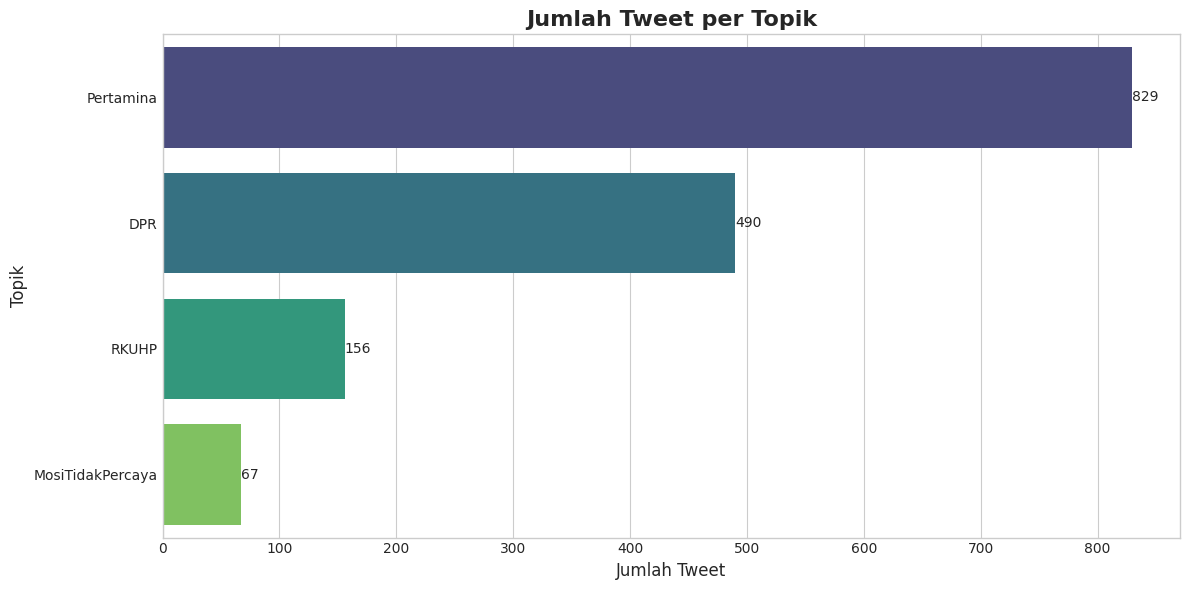

In [5]:
if 'master_df' in locals() and not master_df.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))
    
    ax = sns.countplot(y=master_df['topic'], order=master_df['topic'].value_counts().index, palette='viridis')
    
    ax.set_title('Jumlah Tweet per Topik', fontsize=16, fontweight='bold')
    ax.set_xlabel('Jumlah Tweet', fontsize=12)
    ax.set_ylabel('Topik', fontsize=12)
    
    for container in ax.containers:
        ax.bar_label(container, fontsize=10)
    
    plt.tight_layout()
    plt.show()

### 1.6. Menyimpan DataFrame Master ke File CSV

In [6]:
if 'master_df' in locals() and not master_df.empty:
    output_filename = 'master_dataset_cleaned.csv'
    master_df.to_csv(output_filename, index=False)
    print(f"✅ DataFrame master berhasil disimpan ke file: '{output_filename}'")

✅ DataFrame master berhasil disimpan ke file: 'master_dataset_cleaned.csv'


In [7]:
if 'master_df' in locals() and not master_df.empty:
    print("\n--- ✅ PHASE 1 COMPLETED ---")
    print(f"Final Master DataFrame Shape: {master_df.shape}")
    
    # Mengatur opsi Pandas untuk menampilkan lebih banyak baris
    pd.set_option('display.max_rows', 100)
    
    print("\n--- Pratinjau Master Data (Tabel Interaktif) ---")
    display(master_df)
    
    print("\n--- Info Detail DataFrame ---")
    master_df.info()



--- ✅ PHASE 1 COMPLETED ---
Final Master DataFrame Shape: (1542, 7)

--- Pratinjau Master Data (Tabel Interaktif) ---


,id,text,timestamp,username,reply_to_user,cleaned_text,topic
0,1968910080759214336,"@txtdrimedia Langkahnya terhenti di DPR, tapi ...",2025-09-19 05:28:00,JAditya36003,txtdrimedia,langkahnya terhenti di dpr tapi jejaknya di ru...,DPR
1,1967111501300593152,DPR Nepal resmi dibubarkan\nMau dibersihkan da...,2025-09-14 06:21:00,CakKhum,None,dpr nepal resmi dibubarkan mau dibersihkan dar...,DPR
2,1971033026273677824,Petani (Rakyat) ingin menyampaikan aspirasi ba...,2025-09-25 02:04:00,King_SpeakUp,None,petani rakyat ingin menyampaikan aspirasi baik...,DPR
3,1969754118618284032,Anggota Komisi III DPR Sarifuddin Sudding meng...,2025-09-21 13:22:00,kegblgnunfaedh,None,anggota komisi iii dpr sarifuddin sudding meng...,DPR
4,1968217799840633344,Hari ini Humanies Project turut mengawal drive...,2025-09-17 07:37:00,humaniesproject,None,hari ini humanies project turut mengawal drive...,DPR
...,...,...,...,...,...,...,...
1541,1951326131120119829,Mari kita dukung RKUHP untuk menciptakan masya...,2025-08-01 16:56:00,dLinda16,None,mari kita dukung rkuhp untuk menciptakan masya...,RKUHP
1542,1951326125105230332,"RKUHP, solusi untuk masalah hukum di Indonesia...",2025-08-01 16:56:00,dLinda16,None,rkuhp solusi untuk masalah hukum di indonesia ...,RKUHP
1543,1951326120638615911,"Dukung RKUHP, dukung keadilan untuk semua! #RK...",2025-08-01 16:56:00,dLinda16,None,dukung rkuhp dukung keadilan untuk semua,RKUHP
1544,1967887150936170570,@zenrs Jd inget basa demo tolak RKUHP dan May ...,2025-09-16 09:43:00,Nadiansyah88,zenrs,jd inget basa demo tolak rkuhp dan may day bas...,RKUHP



--- Info Detail DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 1542 entries, 0 to 1545
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             1542 non-null   object        
 1   text           1542 non-null   object        
 2   timestamp      1542 non-null   datetime64[ns]
 3   username       1542 non-null   object        
 4   reply_to_user  642 non-null    object        
 5   cleaned_text   1542 non-null   object        
 6   topic          1542 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 96.4+ KB
